In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/raf_pc/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

temp_repo_dir = "/home/raf_pc/Kemal/Temp/human"
data_repo_dir = "/home/raf_pc/Kemal/Data/sam_bukau"
script_path_infrastructure = "/home/raf_pc/Kemal/RiboSeqAnalysis/infrastructure/"

spt = [os.path.join(data_repo_dir, i) for i in ["Sixtymers_TT1.sam", "Sixtymers_TT2.sam"]]
sps = [os.path.join(data_repo_dir, i) for i in ["Sixtymers_Rep1.sam", "Sixtymers_Rep2.sam", "Sixtymers_NoPK.sam"]]

erb_serb = [f"/home/raf_pc/Kemal/Data/sam_bukau/SeRP/EBP1/Rep{i+1}/IP/IP{i+1}.sam" for i in range(2)]
erb_total = [f"/home/raf_pc/Kemal/Data/sam_bukau/SeRP/EBP1/Rep{i+1}/Total/Total{i+1}.sam" for i in range(2)]
nac_serb = [f"/home/raf_pc/Kemal/Data/sam_bukau/SeRP/NAC/Rep{i+1}/IP/IP{i+1}.sam" for i in range(2)]
nac_total = [f"/home/raf_pc/Kemal/Data/sam_bukau/SeRP/NAC/Rep{i+1}/Total/Total{i+1}.sam" for i in range(2)]

coco_d = [os.path.join(data_repo_dir, i) for i in ["Coco_Dis1.sam", "Coco_Dis2.sam"]]
coco_m = [os.path.join(data_repo_dir, i) for i in ["Coco_Mono1.sam", "Coco_Mono2.sam"]]

exclude_genes = ["ENSG00000160789"]

I = Infrastructre(temp_repo_dir,
                  exclude_genes=exclude_genes,
                  ensembl_release=102,
                  organism="homo_sapiens",
                  #include_gene3d=True,
                  verbose=True)

# Should be first to calculate, since multiprocessing is quite memory inefficient.
I.riboseq_coco = RiboSeqCoco(I.temp_repo_dir, coco_m, coco_d, "cocoassembly",
                             selection="best_transcript", assignment=-15,
                             protein_genome_instance=I.protein_genome,
                             gene_info_dictionary=I.gene_info,
                             exclude_genes=I.exclude_genes, verbose=I.verbose)

I.riboseq_sixtymers = RiboSeqSixtymers(I.temp_repo_dir, spt, sps, "sixtymers",
                                       selection="best_transcript", assignment=-15,
                                       protein_genome_instance=I.protein_genome,
                                       gene_info_dictionary=I.gene_info,
                                       exclude_genes=I.exclude_genes, verbose=I.verbose)

In [3]:
figure_dir = os.path.join(temp_repo_dir, "jupyter_figures_peak_detection_methods_comparison")
os.chdir(figure_dir)

## Periodicity

In [7]:
window_len=180
the_sum = [0] * window_len
the_counts = [0] * window_len
the_sum_tr = [0] * window_len
the_counts_t = [0] * window_len
for gene_id in I.gene_list:
    if I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id) > 1:
        f120 = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        f120 = (f120 / np.sum(f120))[:window_len]
        the_sum = [f120[i] + the_sum[i] if i<len(f120) else the_sum[i] for i in range(window_len)] 
        the_counts = [1 + the_counts[i] if i<len(f120) else the_counts[i] for i in range(window_len)]
    if I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id) > 1:
        f120_t = I.riboseq_sixtymers.translatome.calculate_rpm_positions(gene_id)
        f120_t = (f120_t / np.sum(f120_t))[:window_len]
        the_sum_tr = [f120_t[i] + the_sum_tr[i] if i<len(f120_t) else the_sum_tr[i] for i in range(window_len)]
        the_counts_t = [1 + the_counts_t[i] if i<len(f120_t) else the_counts_t[i] for i in range(window_len)]
the_sum = [the_sum[i]/the_counts[i] * 1000 for i in range(window_len)] 
the_sum_tr = [the_sum_tr[i]/the_counts_t[i] * 1000 for i in range(window_len)] 

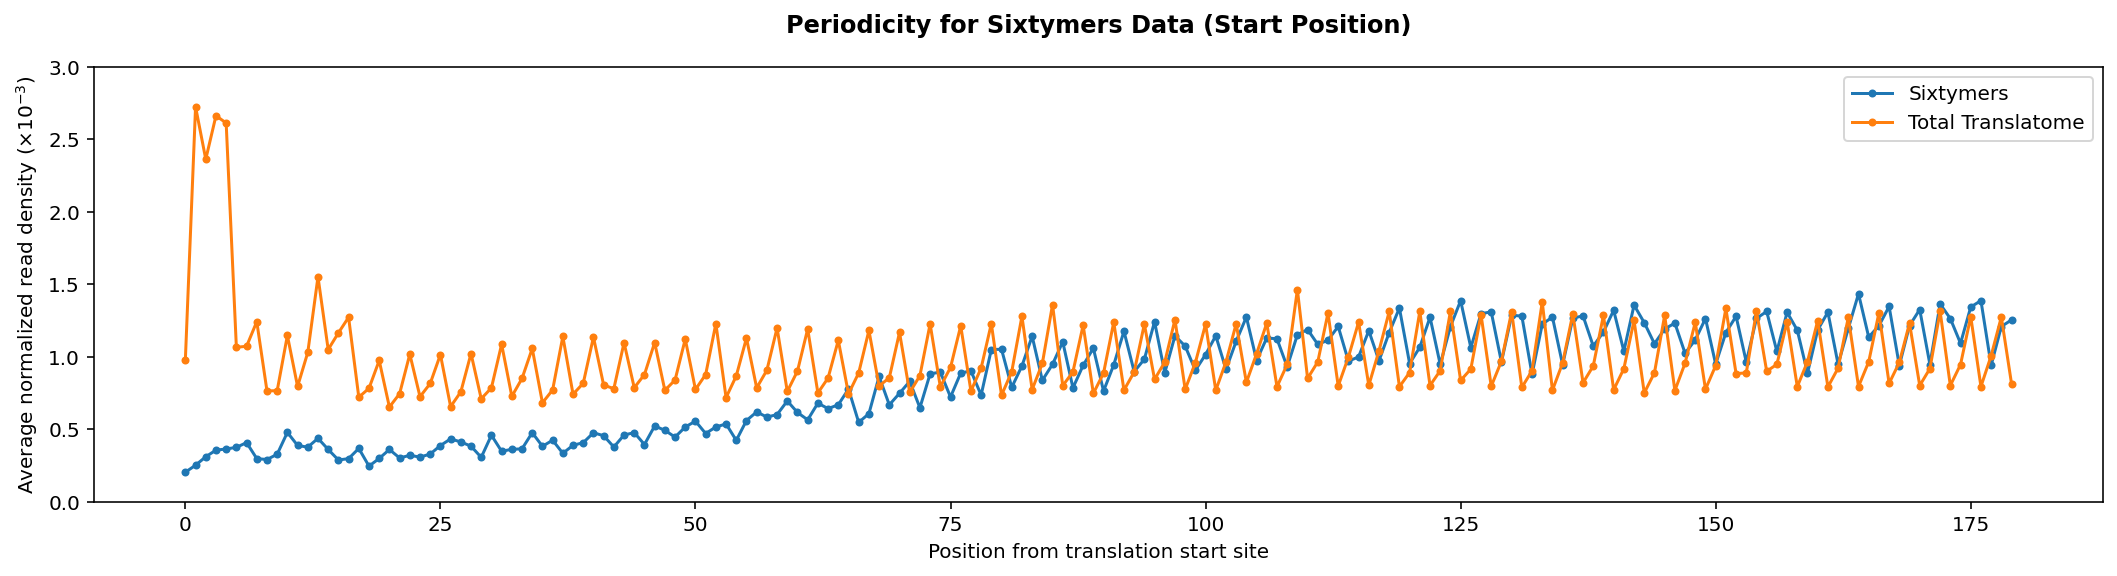

In [8]:
fig = plt.figure(figsize=(18, 4)) 
plt.plot(the_sum, marker=".", label = "Sixtymers")
plt.plot(the_sum_tr, marker=".", label = "Total Translatome")
plt.title("Periodicity for Sixtymers Data (Start Position)", fontweight="bold", y=1.05)
plt.ylabel(r"Average normalized read density ($\times10^{-3}$)")
plt.xlabel("Position from translation start site")
plt.ylim(0,3)
plt.legend()
plt.savefig("sixtymers_periodicity_left.pdf")
plt.show()

In [9]:
window_len=180
the_sum = [0] * window_len
the_counts = [0] * window_len
the_sum_tr = [0] * window_len
the_counts_t = [0] * window_len
for gene_id in I.gene_list:
    if I.riboseq_sixtymers.experiment.calculate_rpkm_genes(gene_id) > 1:
        f120 = I.riboseq_sixtymers.experiment.calculate_rpm_positions(gene_id)
        f120 = (f120 / np.sum(f120))[-window_len:]
        the_sum = [f120[i] + the_sum[i] if i<len(f120) else the_sum[i] for i in range(window_len)] 
        the_counts = [1 + the_counts[i] if i<len(f120) else the_counts[i] for i in range(window_len)]
    if I.riboseq_sixtymers.translatome.calculate_rpkm_genes(gene_id) > 1:
        f120_t = I.riboseq_sixtymers.translatome.calculate_rpm_positions(gene_id)
        f120_t = (f120_t / np.sum(f120_t))[-window_len:]
        the_sum_tr = [f120_t[i] + the_sum_tr[i] if i<len(f120_t) else the_sum_tr[i] for i in range(window_len)]
        the_counts_t = [1 + the_counts_t[i] if i<len(f120_t) else the_counts_t[i] for i in range(window_len)]
the_sum = [the_sum[i]/the_counts[i] * 1000 for i in range(window_len)] 
the_sum_tr = [the_sum_tr[i]/the_counts_t[i] * 1000 for i in range(window_len)] 

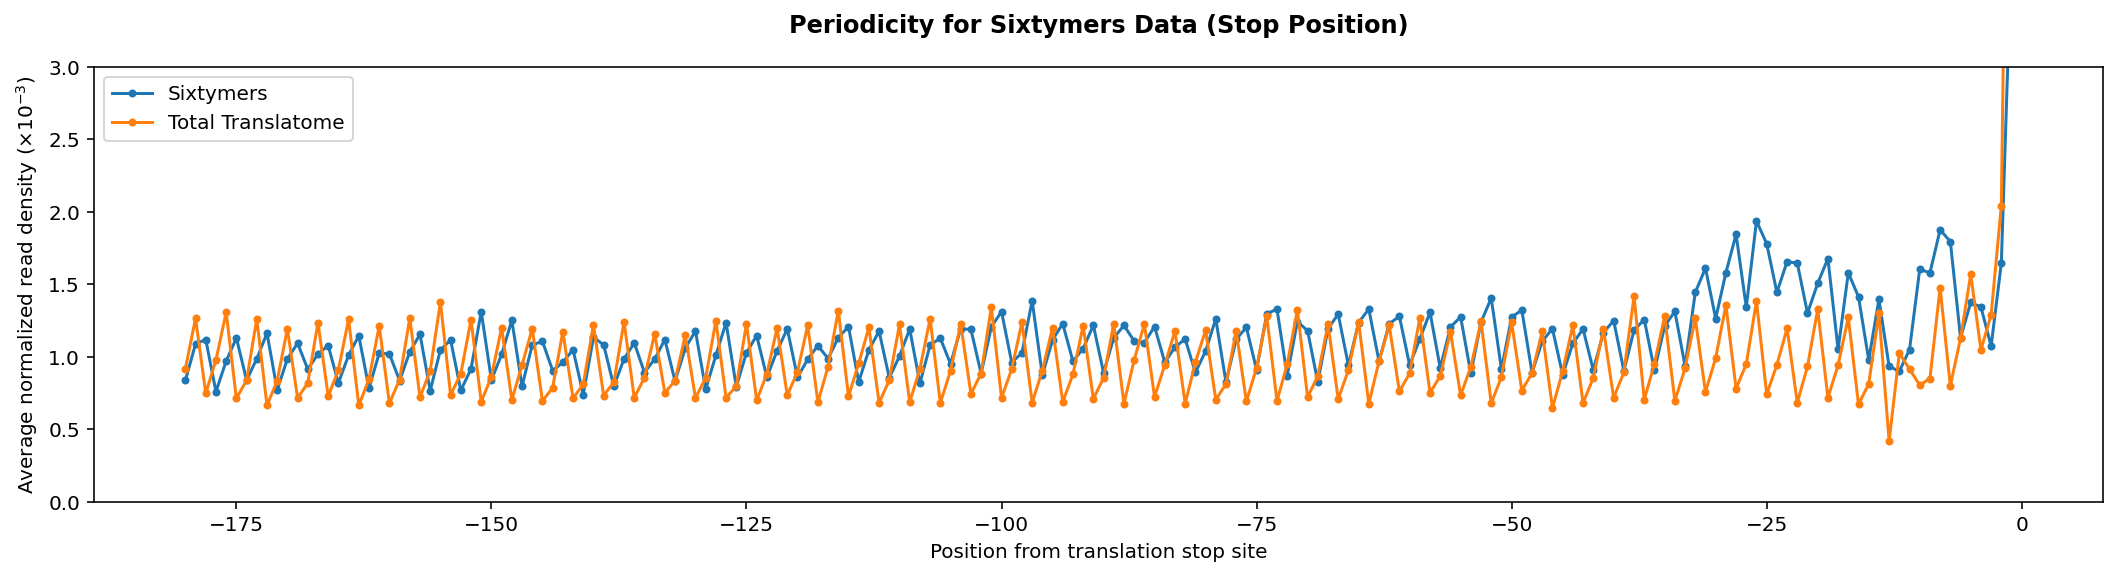

In [10]:
fig = plt.figure(figsize=(18, 4)) 
plt.plot(list(range(-window_len,0,1)), the_sum, marker=".", label = "Sixtymers")
plt.plot(list(range(-window_len,0,1)), the_sum_tr, marker=".", label = "Total Translatome")
plt.title("Periodicity for Sixtymers Data (Stop Position)", fontweight="bold", y=1.05)
plt.ylabel(r"Average normalized read density ($\times10^{-3}$)")
plt.xlabel("Position from translation stop site")
plt.ylim(0,3)
plt.legend()
plt.savefig("sixtymers_periodicity_right.pdf")
plt.show()

## Coco Assembl Data

In [11]:
window_len=180
the_sum = [0] * window_len
the_counts = [0] * window_len
the_sum_tr = [0] * window_len
the_counts_t = [0] * window_len
for gene_id in I.gene_list:
    if I.riboseq_coco.experiment.calculate_rpkm_genes(gene_id) > 1:
        f120 = I.riboseq_coco.experiment.calculate_rpm_positions(gene_id)
        f120 = (f120 / np.sum(f120))[:window_len]
        the_sum = [f120[i] + the_sum[i] if i<len(f120) else the_sum[i] for i in range(window_len)] 
        the_counts = [1 + the_counts[i] if i<len(f120) else the_counts[i] for i in range(window_len)]
    if I.riboseq_coco.translatome.calculate_rpkm_genes(gene_id) > 1:
        f120_t = I.riboseq_coco.translatome.calculate_rpm_positions(gene_id)
        f120_t = (f120_t / np.sum(f120_t))[:window_len]
        the_sum_tr = [f120_t[i] + the_sum_tr[i] if i<len(f120_t) else the_sum_tr[i] for i in range(window_len)]
        the_counts_t = [1 + the_counts_t[i] if i<len(f120_t) else the_counts_t[i] for i in range(window_len)]
the_sum = [the_sum[i]/the_counts[i] * 1000 for i in range(window_len)] 
the_sum_tr = [the_sum_tr[i]/the_counts_t[i] * 1000 for i in range(window_len)] 

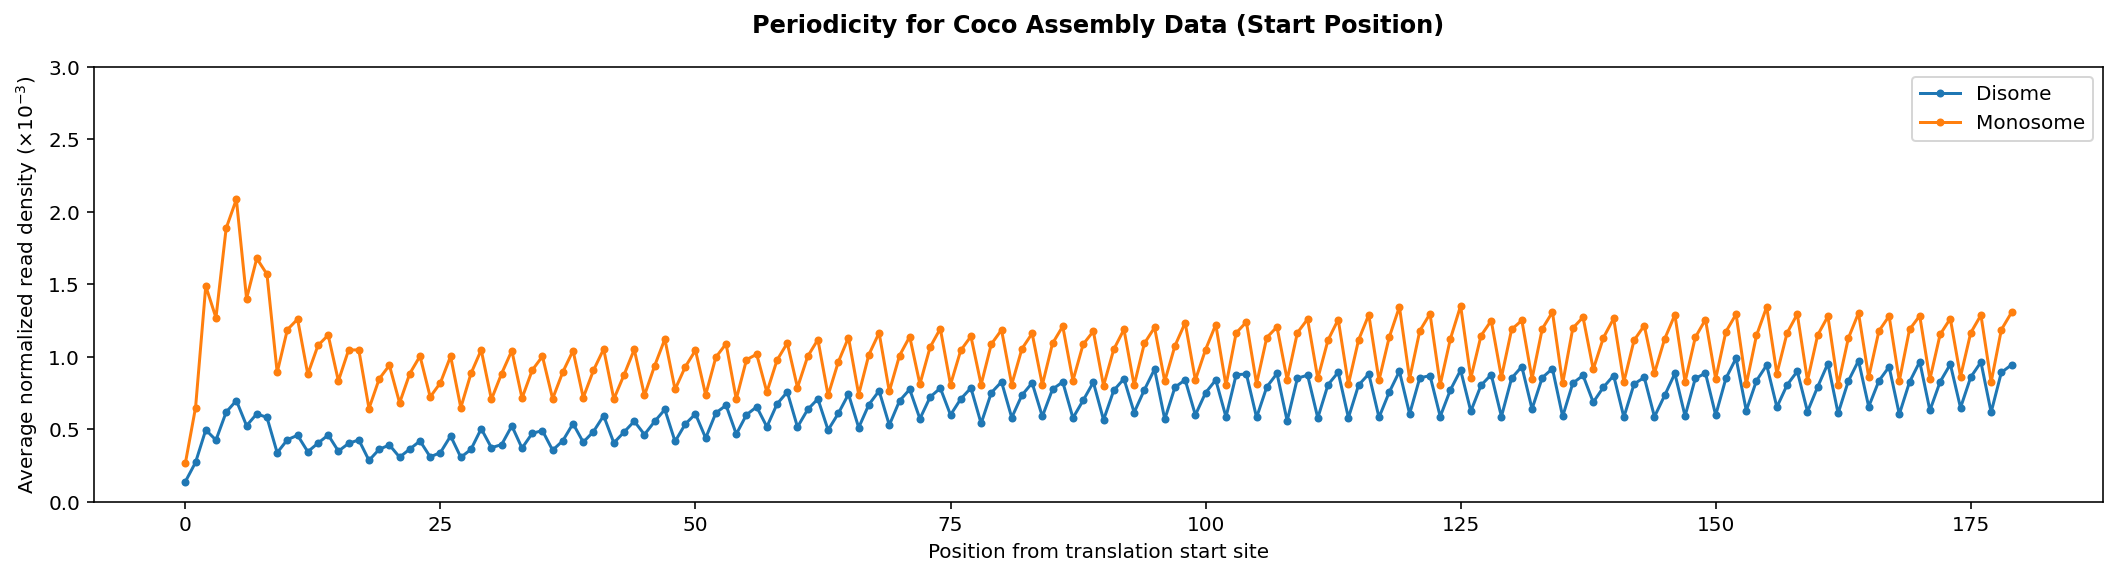

In [12]:
fig = plt.figure(figsize=(18, 4)) 
plt.plot(the_sum, marker=".", label = "Disome")
plt.plot(the_sum_tr, marker=".", label = "Monosome")
plt.title("Periodicity for Coco Assembly Data (Start Position)", fontweight="bold", y=1.05)
plt.ylabel(r"Average normalized read density ($\times10^{-3}$)")
plt.xlabel("Position from translation start site")
plt.ylim(0,3)
plt.legend()
plt.savefig("coco_periodicity_left.pdf")
plt.show()

In [13]:
window_len=180
the_sum = [0] * window_len
the_counts = [0] * window_len
the_sum_tr = [0] * window_len
the_counts_t = [0] * window_len
for gene_id in I.gene_list:
    if I.riboseq_coco.experiment.calculate_rpkm_genes(gene_id) > 1:
        f120 = I.riboseq_coco.experiment.calculate_rpm_positions(gene_id)
        f120 = (f120 / np.sum(f120))[-window_len:]
        the_sum = [f120[i] + the_sum[i] if i<len(f120) else the_sum[i] for i in range(window_len)] 
        the_counts = [1 + the_counts[i] if i<len(f120) else the_counts[i] for i in range(window_len)]
    if I.riboseq_coco.translatome.calculate_rpkm_genes(gene_id) > 1:
        f120_t = I.riboseq_coco.translatome.calculate_rpm_positions(gene_id)
        f120_t = (f120_t / np.sum(f120_t))[-window_len:]
        the_sum_tr = [f120_t[i] + the_sum_tr[i] if i<len(f120_t) else the_sum_tr[i] for i in range(window_len)]
        the_counts_t = [1 + the_counts_t[i] if i<len(f120_t) else the_counts_t[i] for i in range(window_len)]
the_sum = [the_sum[i]/the_counts[i] * 1000 for i in range(window_len)] 
the_sum_tr = [the_sum_tr[i]/the_counts_t[i] * 1000 for i in range(window_len)] 

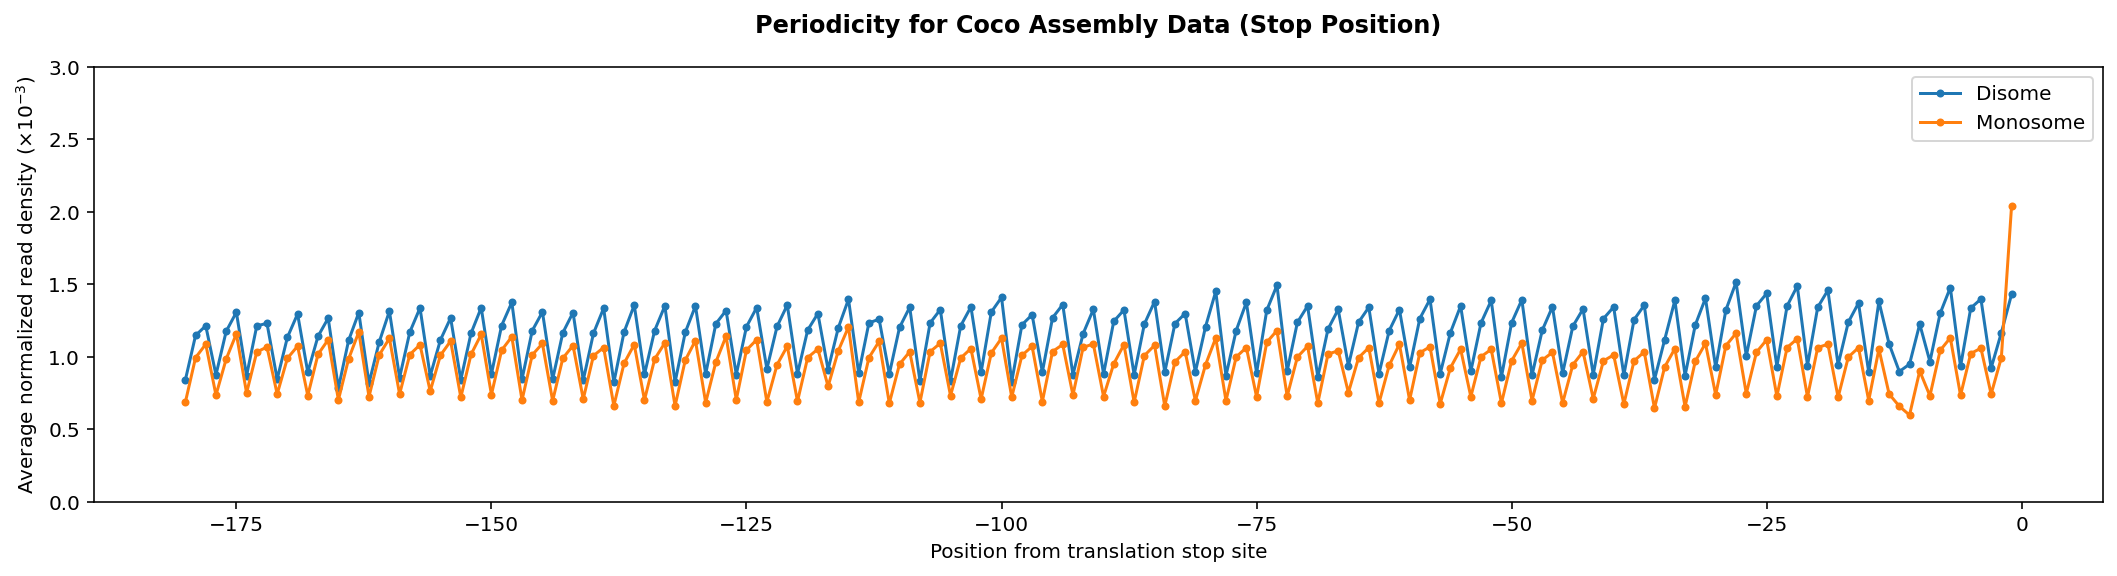

In [14]:
fig = plt.figure(figsize=(18, 4)) 
plt.plot(list(range(-window_len,0,1)), the_sum, marker=".", label = "Disome")
plt.plot(list(range(-window_len,0,1)), the_sum_tr, marker=".", label = "Monosome")
plt.title("Periodicity for Coco Assembly Data (Stop Position)", fontweight="bold", y=1.05)
plt.ylabel(r"Average normalized read density ($\times10^{-3}$)")
plt.xlabel("Position from translation stop site")
plt.ylim(0,3)
plt.legend()
plt.savefig("coco_periodicity_right.pdf")
plt.show()

## Footprint Length

In [ ]:
the_range = list(range(15,45))
trieal = I.riboseq_coco.translatome.assign_for_defined_footprint_lengths(the_range, 32, I.protein_genome, I.gene_info)
ls = list()
for w in the_range:
    counter = 0
    for gene_id in trieal[30].keys():
        counter += np.sum(trieal[w][gene_id])
    ls.append(counter)
del trieal

In [ ]:
plt.bar(the_range, ls, align='center')
plt.xlabel("Footprint Length")
plt.ylabel("Count")
plt.title("Coco Assembly - Monosome", fontweight="bold", y=1.05)
plt.savefig("footlength_Coco_Assembly_Monosome.pdf")
plt.show()

In [ ]:
the_range = list(range(15,45))
trieal = I.riboseq_coco.experiment.assign_for_defined_footprint_lengths(the_range, 32, I.protein_genome, I.gene_info)
ls = list()
for w in the_range:
    counter = 0
    for gene_id in trieal[30].keys():
        counter += np.sum(trieal[w][gene_id])
    ls.append(counter)
del trieal

In [ ]:
plt.bar(the_range, ls, align='center')
plt.xlabel("Footprint Length")
plt.ylabel("Count")
plt.title("Coco Assembly - Disome", fontweight="bold", y=1.05)
plt.savefig("footlength_Coco_Assembly_Disome.pdf")
plt.show()

In [ ]:
the_range = list(range(40,90))
trieal = I.riboseq_sixtymers.experiment.assign_for_defined_footprint_lengths(the_range, 32, I.protein_genome, I.gene_info)
ls = list()
for w in the_range:
    counter = 0
    for gene_id in trieal[45].keys():
        counter += np.sum(trieal[w][gene_id])
    ls.append(counter)
del trieal

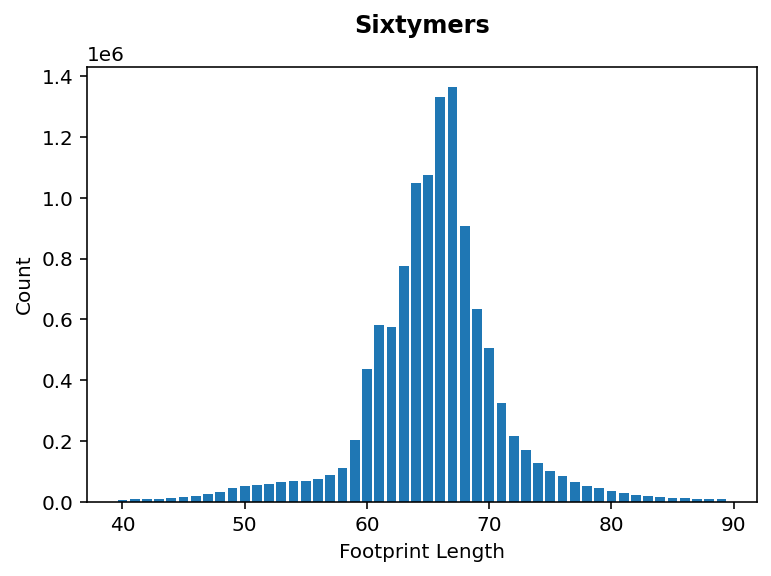

In [6]:
plt.bar(the_range, ls, align='center')
plt.xlabel("Footprint Length")
plt.ylabel("Count")
plt.title("Sixtymers", fontweight="bold", y=1.05)
plt.savefig("footlength_sixtymers_sixtymers.pdf")
plt.show()

In [7]:
the_range = list(range(15,45))
trieal = I.riboseq_sixtymers.translatome.assign_for_defined_footprint_lengths(the_range, 32, I.protein_genome, I.gene_info)
ls = list()
for w in the_range:
    counter = 0
    for gene_id in trieal[30].keys():
        counter += np.sum(trieal[w][gene_id])
    ls.append(counter)
del trieal

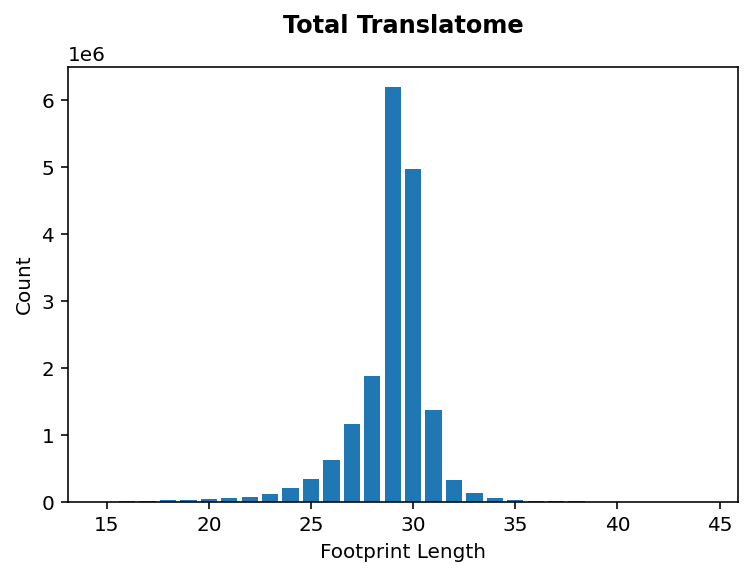

In [8]:
plt.bar(the_range, ls, align='center')
plt.xlabel("Footprint Length")
plt.ylabel("Count")
plt.title("Total Translatome", fontweight="bold", y=1.05)
plt.savefig("footlength_sixtymers_totaltranslatome.pdf")
plt.show()